# Project 2: Ames Housing Saleprice Prediction
---
Project notebook organisation:<br>
[1 - Exploratory Data Analysis](./1_exploratory_data_analysis.ipynb)<br>
[2 - Preprocessing and Feature Engineering](./2_preprocessing_and_feature_engineering.ipynb)<br>
[3 - Model Tuning and Insights](./3_model_tuning_and_insights.ipynb)<br>
**3.1 - Model Performance with Automated Feature Selection** (current notebook)<br>
<br>
<br>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import featuretools as ft
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV 
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

sns.set_style('ticks')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 3000)

%matplotlib inline

## Introduction
---

In this appendix, I used the [`featuretools` library](https://github.com/Featuretools/featuretools) to automate the feature engineering and preprocessing process. Compared to the manual feature cleaning that I did in [notebook #2](./2_preprocessing_and_feature_engineering.ipynb), this not only saves time, but also generates many more potentially useful features. I then evaluated the resulting features using the same model I developed in the previous notebook.

In summary, while `featuretools` greatly saved the amount of time needed for feature preprocessing, in this particular case, it did not outperform manual feature cleaning. 

### Contents

1. [Build preprocessing function](#Build-preprocessing-function)
2. [Check preprocessing function](#Check-preprocessing-function)
3. [Data transformations](#Transformations)
4. [Final preprocessing workflow](#Final-preprocessing-workflow)
5. [Export preorcessed data](#Export-data)

## Preprocessing with `featuretools`
---

### Import data

In [4]:
# import train
train = pd.read_csv ("../data/train.csv")

# check df
print(train.columns)
train.info()

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood De

### Convert data to int/float32
To save time during `featuretools` preprocessing, columns were first converted to less memory-intensive types.

In [5]:
def convert_columns(df):  
    for col in df.columns:    
        col_type = df[col].dtype
        if (col_type == 'object'):
                df[col] = df[col].astype('category')    
        if (col_type == 'int64'):
                df[col] = df[col].astype('int32')   
        if (col_type == 'float64'):
                df[col] = df[col].astype('float32')  
    return df

for col in train:
    convert_columns(train)
    
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int32
PID                2051 non-null int32
MS SubClass        2051 non-null int32
MS Zoning          2051 non-null category
Lot Frontage       1721 non-null float32
Lot Area           2051 non-null int32
Street             2051 non-null category
Alley              140 non-null category
Lot Shape          2051 non-null category
Land Contour       2051 non-null category
Utilities          2051 non-null category
Lot Config         2051 non-null category
Land Slope         2051 non-null category
Neighborhood       2051 non-null category
Condition 1        2051 non-null category
Condition 2        2051 non-null category
Bldg Type          2051 non-null category
House Style        2051 non-null category
Overall Qual       2051 non-null int32
Overall Cond       2051 non-null int32
Year Built         2051 non-null int32
Year Remod/Add     2051 non-null i

### Separate x and y columns

In [6]:
x = train.loc[:, train.columns != 'SalePrice']
y = train[['SalePrice']]

print(x.shape)
print(y.shape)

(2051, 80)
(2051, 1)


### Create entities

In [7]:
entity_set_x = ft.EntitySet(id = 'x')

entity_set_x = entity_set_x.entity_from_dataframe(entity_id = 'x',
                                             dataframe = x,
                                             )

2019-11-04 17:00:09,982 featuretools.entityset - WARNING    ('Using first column as index. ', 'To change this, specify the index parameter')


In [12]:
# check that it has read all the data in
entity_set_x

Entityset: x
  Entities:
    x [Rows: 2051, Columns: 80]
  Relationships:
    No relationships

### Create primitives

In [13]:
list_of_primitives = ft.primitives.list_primitives()
list_of_primitives[list_of_primitives.type == 'aggregation']

name         type                                        description
0               mean  aggregation         Computes the average for a list of values.
1               last  aggregation               Determines the last value in a list.
2              count  aggregation  Determines the total number of values, excludi...
3               skew  aggregation  Computes the extent to which a distribution di...
4      n_most_common  aggregation           Determines the `n` most common elements.
5           num_true  aggregation                Counts the number of `True` values.
6              trend  aggregation      Calculates the trend of a variable over time.
7                max  aggregation  Calculates the highest value, ignoring `NaN` v...
8    time_since_last  aggregation  Calculates the time elapsed since the last dat...
9               mode  aggregation       Determines the most commonly repeated value.
10               any  aggregation       Determines if any value is 'True' in a list.
11               sum  aggregation     Calculates the total addition, ignoring `NaN`.
12               std  aggregation  Computes the dispersion relative to the mean v...
13  avg_time_between  aggregation  Computes the average number of seconds between...
14            median  aggregation  Determines the middlemost number in a list of ...
15      percent_true  aggregation           Determines the percent of `True` values.
16        num_unique  aggregation  Determines the number of distinct values, igno...
17  time_since_first  aggregation  Calculates the time elapsed since the first da...
18               min  aggregation  Calculates the smallest value, ignoring `NaN` ...
19               all  aggregation     Calculates if all values are 'True' in a list.

In [14]:
list_of_primitives[list_of_primitives.type == 'transform']

name       type                                        description
20                          cum_sum  transform                     Calculates the cumulative sum.
21                   num_characters  transform   Calculates the number of characters in a string.
22                        not_equal  transform  Determines if values in one list are not equal...
23                               or  transform              Element-wise logical OR of two lists.
24              time_since_previous  transform  Compute the time since the previous entry in a...
25                        longitude  transform  Returns the second tuple value in a list of La...
26                 multiply_boolean  transform  Element-wise multiplication of two lists of bo...
27                       is_weekend  transform           Determines if a date falls on a weekend.
28                            equal  transform  Determines if values in one list are equal to ...
29                modulo_by_feature  transform  Return the modulo of a scalar by each element ...
30                     greater_than  transform  Determines if values in one list are greater t...
31                 multiply_numeric  transform          Element-wise multiplication of two lists.
32                            month  transform          Determines the month value of a datetime.
33               less_than_equal_to  transform  Determines if values in one list are less than...
34                   modulo_numeric  transform                  Element-wise modulo of two lists.
35                       percentile  transform  Determines the percentile rank for each value ...
36                           negate  transform                           Negates a numeric value.
37          subtract_numeric_scalar  transform   Subtract a scalar from each element in the list.
38                           minute  transform        Determines the minutes value of a datetime.
39            divide_numeric_scalar  transform       Divide each element in the list by a scalar.
40                        less_than  transform  Determines if values in one list are less than...
41                         absolute  transform           Computes the absolute value of a number.
42                          cum_min  transform                 Calculates the cumulative minimum.
43                             isin  transform  Determines whether a value is present in a pro...
44               add_numeric_scalar  transform            Add a scalar to each value in the list.
45                             hour  transform           Determines the hour value of a datetime.
46            greater_than_equal_to  transform  Determines if values in one list are greater t...
47                        cum_count  transform                   Calculates the cumulative count.
48                        num_words  transform  Determines the number of words in a string by ...
49                 not_equal_scalar  transform  Determines if values in a list are not equal t...
50                          is_null  transform                     Determines if a value is null.
51                        haversine  transform  Calculates the approximate haversine distance ...
52                   divide_numeric  transform                Element-wise division of two lists.
53                          weekday  transform    Determines the day of the week from a datetime.
54                              and  transform             Element-wise logical AND of two lists.
55                     equal_scalar  transform  Determines if values in a list are equal to a ...
56                         latitude  transform  Returns the first tuple value in a list of Lat...
57          multiply_numeric_scalar  transform     Multiply each element in the list by a scalar.
58                             year  transform           Determines the year value of a datetime.
59        less_than_equal_to_scalar  transform  Determines if values are less than or equal to...
60           

In [15]:
# select list of aggregation primitives to use on data
agg_primitives = ['median','sum','n_most_common','count','time_since_last','avg_time_between','mean',\
                 'skew']

In [16]:
# select list of transform primitives to use on data
trans_primitives = ['diff','greater_than_equal_to','time_since','subtract_numeric','divide_numeric',\
                   'is_null','percentile','less_than']

### Create features using the deep feature synthesis (dfs) object
Using the above primitives, `featuretools` produced 4895 features.

In [17]:
features, feature_names = ft.dfs(entityset = entity_set_x,
                                target_entity = 'x',
                                agg_primitives=agg_primitives,
                                trans_primitives=trans_primitives,
                                max_depth =1,
                                verbose=True)

Built 4895 features
Elapsed: 00:08 | Progress: 100%|██████████


In [18]:
features.shape

(2051, 4895)

### Feature cleaning

In [19]:
# drop columns with inf and nan
x = features.copy()
x = x.reset_index()

x = x.replace([np.inf, -np.inf], np.nan)
x = x.dropna(axis=1, how='any')

## Model-building
---

### One-hot encoding

In [20]:
train_dummies = pd.get_dummies(x, drop_first = True)
train_dummies.shape

(2051, 3579)

### Train-test-split

In [25]:
# train test split
np.random.seed(100)
xtrain, xtest, ytrain, ytest = train_test_split(train_dummies, y, test_size = 0.3, random_state = 7)
    
print(xtrain.shape)
print(ytrain.shape)

(1435, 3579)
(1435, 1)


### Scale data

In [26]:
from scipy.special import boxcox1p

# scale data - standardscaler
scaler = StandardScaler()

xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

# ytrain_scaled = scaler.fit_transform(ytrain)
# ytest_scaled = scaler.transform(ytest)

# transform y
ytrain['SalePrice'] = boxcox1p(ytrain['SalePrice'],0.15)
ytest['SalePrice'] = boxcox1p(ytest['SalePrice'],0.15)

### Hyperparameter tuning

In [27]:
enet_alpha = np.arange(0, 1, 0.5)
enet_ratio = [.01, .1, .2, .3, .5, .7, .9, .95, .99, 1]

# fits multiple alphas and rhos
enetcv = ElasticNetCV(alphas = enet_alpha, l1_ratio = enet_ratio, cv = 3, n_jobs = -1, verbose=True)
enetcv = enetcv.fit(xtrain_scaled, ytrain)

print('optimal enet alpha: ', enetcv.alpha_)
print('optimal enet lambda: ', enetcv.l1_ratio_)
print('best elastic net R2: ', enetcv.score(xtrain_scaled, ytrain))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
............................................................[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


optimal enet alpha:  0.5
optimal enet lambda:  0.1
best elastic net R2:  0.9194684252622103


In [28]:
# instantiate models with previously selected hyperparameters
enet = ElasticNet(alpha = enetcv.alpha_, l1_ratio = enetcv.l1_ratio_)

### CV (train)

In [29]:
# define CV function
nfolds = 5 
np.random.seed(100)

def crossval(model, x, y):
    kf = KFold(nfolds, shuffle = True, random_state = 7)
    rmse = np.sqrt(-cross_val_score(model, x, y, cv = kf, scoring = 'neg_mean_squared_error'))
    r2 = cross_val_score(model, x, y, cv = kf)
    return 'mean CV R2:', r2.mean(), \
            'mean CV RMSE:', rmse.mean(), \
            'CV R2 variance:', r2.var(), \
            'CV RMSE variance:', rmse.var()

In [30]:
# baseline model
# use dummy regressor to predict using mean
dummy_regressor = DummyRegressor()
print('Baseline model: \n', crossval(dummy_regressor, xtrain_scaled, ytrain))

# elastic net regression
print('ELASTIC NET: \n', crossval(enet, xtrain_scaled, ytrain))

Baseline model: 
 ('mean CV R2:', -0.009097800823119683, 'mean CV RMSE:', 2.5033834921525204, 'CV R2 variance:', 8.25759758736003e-05, 'CV RMSE variance:', 0.03571010636266923)
ELASTIC NET: 
 ('mean CV R2:', 0.8611922896542484, 'mean CV RMSE:', 0.9161701766926802, 'CV R2 variance:', 0.0016309677024140025, 'CV RMSE variance:', 0.017221024235979276)


### Model performance

The model performance using automatically preprocessed features are summarised below:

| Model 	| R2      	| RMSE    	|
|-------	|---------	|---------	|
|Train - baseline model|-0.00909|2.50338
|Test - baseline model |-0.00106|2.47530
|Train - elastic net   |0.86119|0.91617
|Test - elastic net    |0.90678|0.75532

For comparison, the model score using manual preprocessing are:

| Model 	| R2      	| RMSE    	|
|-------	|---------	|---------	|
|Train - elastic net regression|0.91801|0.71084|
|Test - elastic net regression|0.91851|0.71937|

One can see that manual preprocessing produced a better score in this case. This is likely because as this dataset had relatively few features, manual preprocessing was able to better identify specific ways to treat each column, instead of applying a blanket treatment to all columns.

The features selected in this case also greatly differ from those selected by the model from manually preprocessed data. For instance, the top 5 features in the automated model are:
- `Gr Liv Area` < `BsmtFin SF 1` (whether `Gr Liv Area` is less than `BsmtFin SF 1`)
- `Mo Sold` < `Bsmt Full Bath `
- `Overall Qual`
- `Kitchen AbvGr` - `Overall Qual` (`Kitchen AbvGr` minus `Overall Qual`)
- `Overall Qual` / `Yr Sold` (`Overall Qual` divide by `Yr Sold`)

Whereas in the original model, the top five coefficients are:
- `Gr Liv Area` 	
- `Overall Qual` 	
- `Overall Cond`
- `age_sold`	
- `Lot Area`

The coefficients of the original model are also a lot easier to interprete in this case.

In [38]:
# --------------------------------------- DEFINE ERROR METRICS ---------------------------------------
def rmse(ytest, ypred):
    return np.sqrt(mean_squared_error(ytest, ypred))

# ----------------------------------------- FIT BASELINE MODEL ----------------------------------------
# use dummy regressor to predict using mean
dummy_regressor = DummyRegressor()
baseline_mod = dummy_regressor.fit(xtrain_scaled, ytrain)
baseline_pred = dummy_regressor.predict(xtest_scaled)

print(f'baseline R2: {dummy_regressor.score(xtest_scaled, ytest)}')
print(f'baseline RMSE: {rmse(ytest, baseline_pred)}')

# --------------------------------------- FIT ELASTIC NET MODEL ---------------------------------------
# fit model to train data
enet_mod = enet.fit(xtrain_scaled, ytrain)
# predict on test data
ypred = enet_mod.predict(xtest_scaled)
# evaluate model performance
print('elastic net test R2: ', enet_mod.score(xtest_scaled, ytest))
print('elastic net test RMSE: ', rmse(ytest, ypred))

baseline R2: -0.0010643924624773593
baseline RMSE: 2.4753085804577317
elastic net test R2:  0.9067870808032331
elastic net test RMSE:  0.7553294098640038


#### Coefficients

the model produced 379 non-zero coefficients.


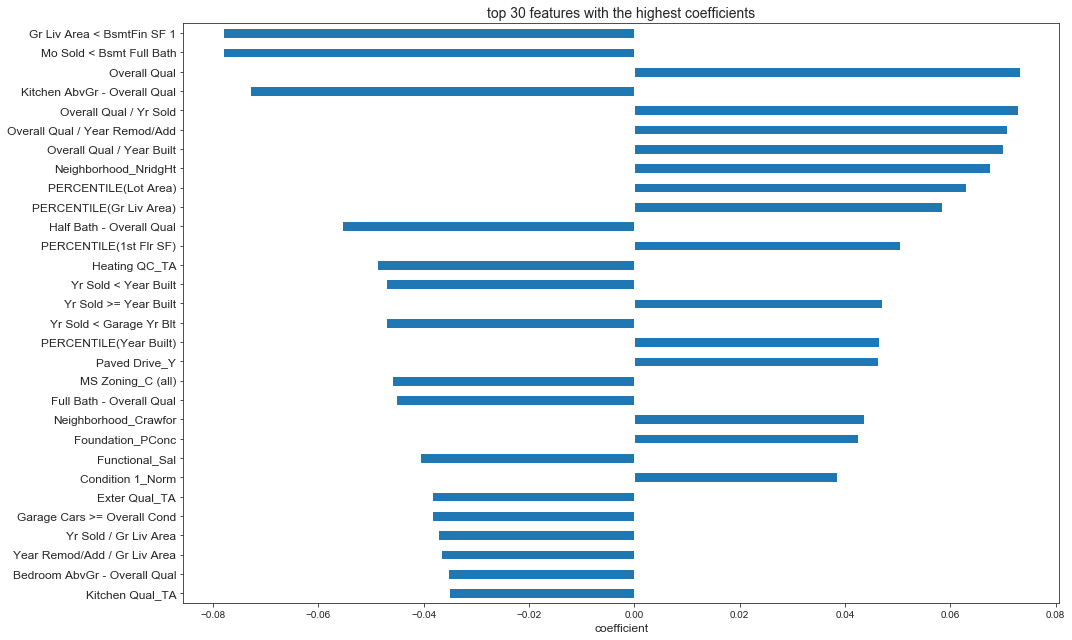

In [32]:
# ---------------------------------------- IDENTIFYING TOP FEATURES ----------------------------------------

# get list of coefficients that are not 0
coef_labels = [col for col in train_dummies.columns if col != 'SalePrice'] # column labels
enet_coef = pd.DataFrame(enet_mod.coef_, index = coef_labels)              # get coefficients from best model
enet_coef = enet_coef[enet_coef[0] != 0]                                   # get non-zero coefficients
print(f'the model produced {enet_coef.shape[0]} non-zero coefficients.')

# sort by absolute values
enet_coef = enet_coef.reindex(enet_coef[0].abs().sort_values(ascending=True).index)

# plot top 30 coefficients
enet_coef.tail(30).plot.barh(figsize=(15,9), legend = None)
plt.title('top 30 features with the highest coefficients',fontsize=14)
plt.xlabel('coefficient', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

#### Residuals

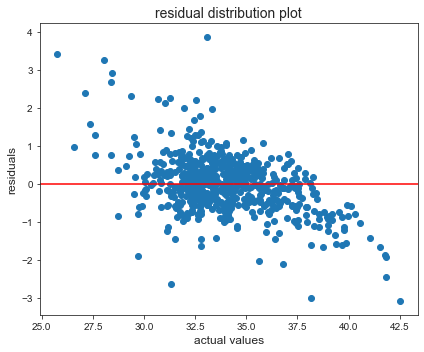

In [33]:
# plot residuals
resid = ypred - ytest.SalePrice

plt.rcParams['figure.figsize'] = (6.0, 5.0)
plt.scatter(ytest.SalePrice, resid)
plt.axhline(0, linestyle='-', color='r')
plt.title('residual distribution plot',fontsize=14)
plt.xlabel('actual values',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.tight_layout()

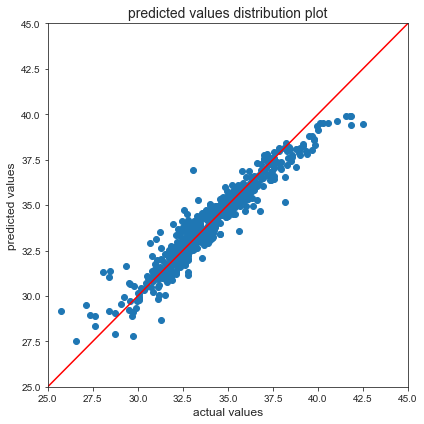

In [37]:
# plot ypred vs ytrue
fig, ax = plt.subplots(figsize=(6.0, 6.0))
ax.scatter(ytest.SalePrice, ypred)
ax.set_title('predicted values distribution plot',fontsize=14)
ax.set_xlabel('actual values',fontsize=12)
ax.set_ylabel('predicted values',fontsize=12)
ax.set_xlim(25,45)
ax.set_ylim(25,45)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="r")
plt.tight_layout()